In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Устанавливаем параметры холста для всех графиков matplotlib
sns.set(palette='Set2', font_scale=1.2)

In [2]:
# ! pip install plotly
import plotly
import plotly.graph_objects as go

Больше материалов о библиотеках можно узнать в туториалах [здесь](https://mipt-stats.gitlab.io/courses/python.html)

# Временные ряды. 
## Работа с данными

В этом ноутбуке мы будем работать с данными о продажах тороговой сети [Walmart](https://en.wikipedia.org/wiki/Walmart), крупнейшей в мире сети оптовой и розничной торговли. Данные были предствлены на [соревновании в Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview) аж 7 лет назад, и тогда считались одним из самых крупных наборов открытых данных. Само соревнование проводилось среди соискателей работы в Walmart (видимо, искали data science специалистов). Цель соревнования состояла в том, чтобы спрогнозировать продажи для каждого отдела (department) в каждом из представленных магазинов (store).

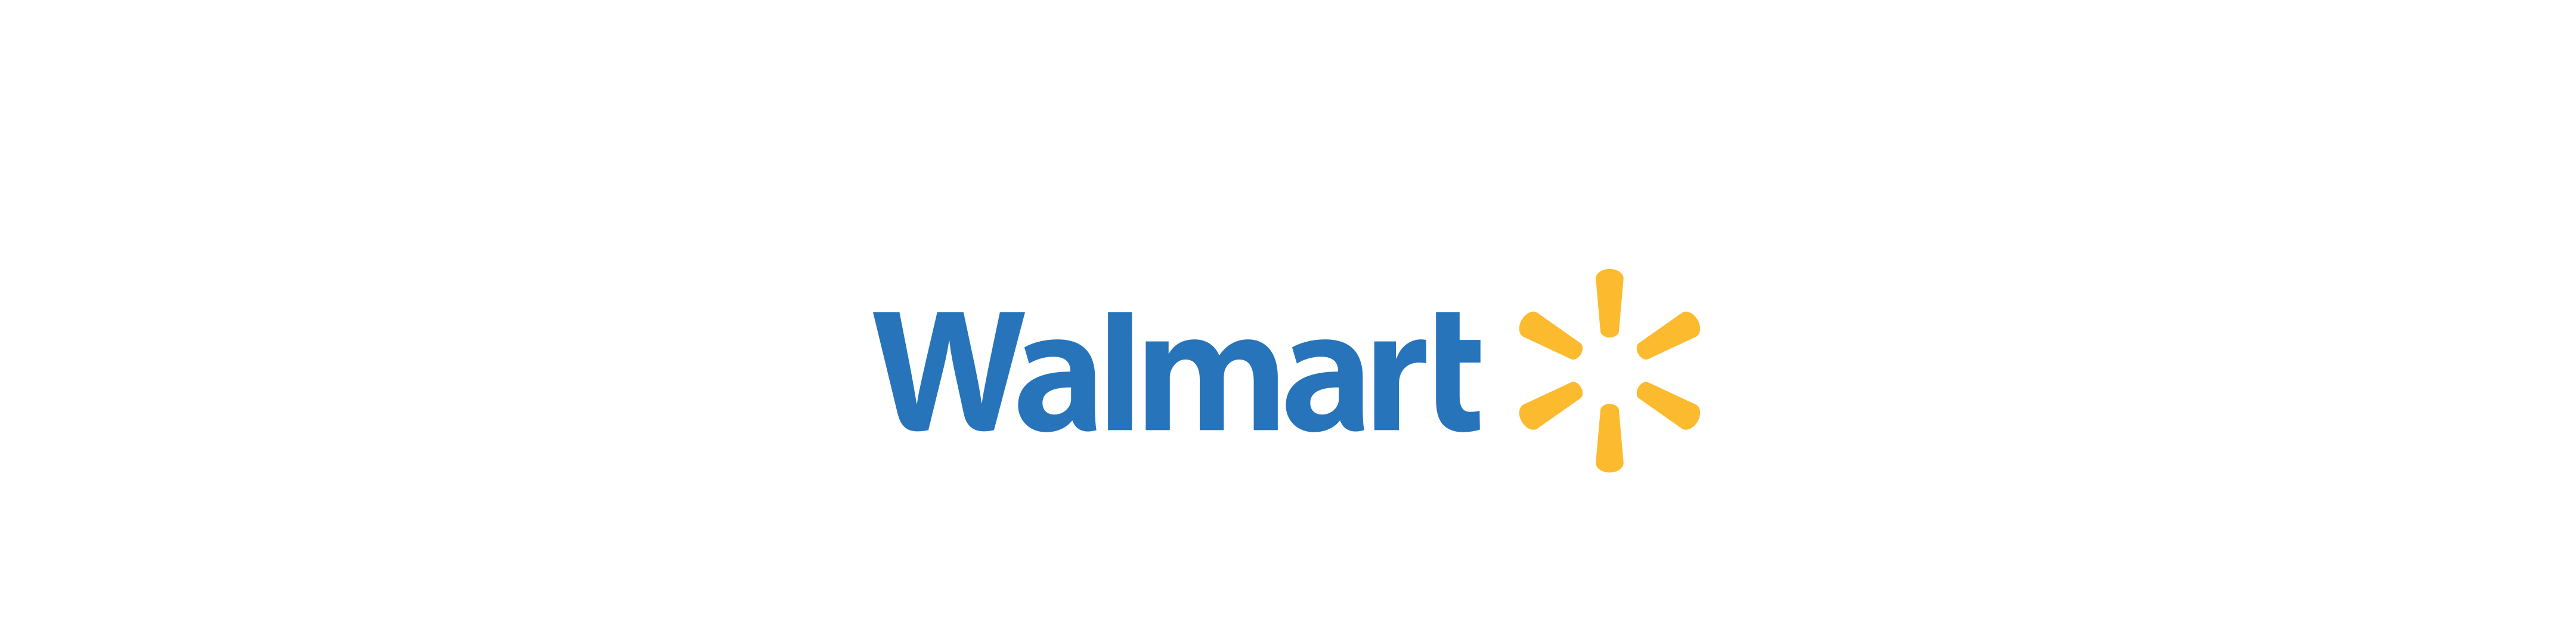

Скачать данные можно во [вкладке Data](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data) на странице соревнования.

Всего имеется 4 файла с данными: `stores.csv`, `train.csv`, `test.csv`, `features.csv`. В этом занятии мы будем использовать все кроме теста. `stores.csv` содержит информацию о магазинах, `features.csv` &mdash; дополнительную информацию о магазинах, отделах и региональной активности, в регионе магазина, `train.csv` &mdash; информацию о продажах.

Данные содержат разные колонки: `Store` &mdash; номер магазина, `Dept` &mdash; номер отдела, `Date` &mdash; дата, `Type` &mdash; тип магазина, `Weekly_Sales` &mdash; продажи за неделю в данном магазине в данном отделе, `IsHoliday` &mdash; явялйется ли неделя выходной, праздничной, `Temperature` &mdash; средняя температура в регионе, `Fuel_Price` &mdash; цена бензина в регионе, `Markdown1-5` &mdash; анонимизированная информация о скидках, `CPI` &mdash; индекс потребительских цен (consumer price index), `Unemployment` &mdash; уровень безработицы в регионе.

### Как считывать и сохранять временные данные с помощью pandas

#### read_csv
Попробуем самым обычным образом считать файл.

Так как в `train.csv` содержатся данные о продажах, то назовем DataFrame `sales`.

In [3]:
sales = pd.read_csv("./Walmart/train.csv")
sales.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

#### info
Выведем основную информацию о продажах с помощью функции `info`.

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


#### to_datetime
Мы видим, что все типы колонок опредились pandas правильно кроме `Date`. Нам бы хотелось, чтобы даты были специальном формате `datetime`. Для этого воспользуемся функцией `to_datetime`.

In [5]:
sales.Date = pd.to_datetime(sales.Date)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


Теперь даты стали правильного формата.

Также есть способ распознать даты с самого начала при загрузке DataFrame. Для этого нужно указать колнки с датами в аргументе `parse_dates`.

In [6]:
sales = pd.read_csv("./Walmart/train.csv", parse_dates=['Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


#### Форматы дат 
Предположим, что нас попросили кому-нибудь, например русскому партнеру компании, передать полученные данные со стандартным для России форматом дат `DD.MM.YYYY`. Для этого укажем заданный формат в аргументе `date_format` в функции `to_csv`.

> Обратим внимание на то, **как задается дата**. Чтобы перевести дату в строку используется функция `	
strftime`. Она поддерживает специальный формат, в котором каждая деректива, будт то год `Y`, месяц `m`, день `d`, час `H`, минута `M`, секунда `S` и т.д., передается через `%`. Подробнее про формат записи дат можно посмотреть по [ссылке](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

In [7]:
sales.to_csv("./Walmart/sales.csv", date_format="%d.%m.%Y", index=None)

Посмотрим что получилось в файле.

In [8]:
with open("./Walmart/sales.csv", "r") as file:
    n = 0
    for line in file.readlines():
        if n == 5:
            break
        print(line)
        n += 1

Store,Dept,Date,Weekly_Sales,IsHoliday

1,1,05.02.2010,24924.5,False

1,1,12.02.2010,46039.49,True

1,1,19.02.2010,41595.55,False

1,1,26.02.2010,19403.54,False



Видим, что даты записались в нужном формате.

Теперь попробуем их прочитать, укажем нужную колонку для парсинга дат.

In [9]:
sales = pd.read_csv("./Walmart/sales.csv", parse_dates=['Date'])
sales.head()

Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-05-02      24924.50      False
1      1     1 2010-12-02      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-05-03      21827.90      False

Даты распознались, но неправильно. Местами день и месяц перепутаны. Для того, чтобы данные считались правильно, установим аргумент `dayfirst` равным `True` в функции `read_csv`.

In [10]:
sales = pd.read_csv("./Walmart/sales.csv", parse_dates=['Date'], dayfirst=True)
sales.head()

Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False

Теперь даты считались правильно. В более сложных случаях, можно написать свою функцию для распознавания дат и поставить ее как аргумент `date_parser`. Для нашего примера она будет выглядеть так.

In [11]:
sales = pd.read_csv("./Walmart/sales.csv", parse_dates=['Date'], 
                    date_parser=lambda s: datetime.strptime(s, "%d.%m.%Y"))
sales.head()

Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False

### Работа с датами в pandas

Считаем таблицу с различными дополнительми признаками.

In [37]:
features[features.Store==1].

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [38]:
features = pd.read_csv("./Walmart/features.csv", parse_dates=['Date'])
features.sort_values('Date').head(20)

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0         1 2010-02-05        42.31       2.572        NaN        NaN   
2730     16 2010-02-05        19.79       2.580        NaN        NaN   
5460     31 2010-02-05        39.05       2.572        NaN        NaN   
3640     21 2010-02-05        39.05       2.572        NaN        NaN   
4550     26 2010-02-05         9.55       2.788        NaN        NaN   
7280     41 2010-02-05        30.27       2.580        NaN        NaN   
2548     15 2010-02-05        19.83       2.954        NaN        NaN   
5642     32 2010-02-05        34.43       2.580        NaN        NaN   
910       6 2010-02-05        40.43       2.572        NaN        NaN   
3458     20 2010-02-05        25.92       2.784        NaN        NaN   
1274      8 2010-02-05        34.14       2.572        NaN        NaN   
2366     14 2010-02-05        27.31       2.784        NaN        NaN   
5824     33 2010-02-05        58.40       2.962        NaN        NaN   
4186     24 2010-02-05        22.43       2.954        NaN        NaN   
4004     23 2010-02-05        15.25       2.788        NaN        NaN   
6916     39 2010-02-05        44.30       2.572        NaN        NaN   
4732     27 2010-02-05        27.19       2.954        NaN        NaN   
7098     40 2010-02-05        14.48       2.788        NaN        NaN   
3822     22 2010-02-05        24.36       2.788        NaN        NaN   
1820     11 2010-02-05        46.04       2.572        NaN        NaN   

      MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0           NaN        NaN        NaN  211.096358         8.106      False  
2730        NaN        NaN        NaN  189.381697         7.039      False  
5460        NaN        NaN        NaN  210.752605         8.324      False  
3640        NaN        NaN        NaN  210.752605         8.324      False  
4550        NaN        NaN        NaN  131.527903         8.488      False  
7280        NaN        NaN        NaN  189.381697         7.541      False  
2548        NaN        NaN        NaN  131.527903         8.350      False  
5642        NaN        NaN        NaN  189.381697         9.014      False  
910         NaN        NaN        NaN  212.622352         7.259      False  
3458        NaN        NaN        NaN  204.247194         8.187      False  
1274        NaN        NaN        NaN  214.471451         6.299      False  
2366        NaN        NaN        NaN  181.871190         8.992      False  
5824        NaN        NaN        NaN  126.442065        10.115      False  
4186        NaN        NaN        NaN  131.527903         8.326      False  
4004        NaN        NaN        NaN  131.527903         5.892      False  
6916        NaN        NaN        NaN  209.852966         8.554      False  
4732        NaN        NaN        NaN  135.352461         8.237      False  
7098        NaN        NaN        NaN  131.527903         5.892      False  
3822        NaN        NaN        NaN  135.352461         8.283      False  
1820        NaN        NaN        NaN  214.424881         7.368      False

Выделим первую дату из данных.

In [13]:
date = features.Date[0]
date

Timestamp('2010-02-05 00:00:00')

#### date, day, month, year
Выделим дату, а также день, месяц и год.

In [14]:
print(f"Дата: {date.date()}\n\n"
      f"День: {date.day}\n"
      f"Месяц: {date.month} ({date.month_name()})\n"
      f"Год: {date.year}\n")

Дата: 2010-02-05

День: 5
Месяц: 2 (February)
Год: 2010



#### day_of_week, day_name, day_of_year, weekofyear
Также можем рассмотреть такие характеристики как день недели, день в году, неделя в году.

In [15]:
print(f"День недели: {date.day_of_week} ({date.day_name()})\n"
      f"День года: {date.day_of_year}\n"
      f"Неделя в году: {date.weekofyear}\n")

День недели: 4 (Friday)
День года: 36
Неделя в году: 5



Хоть время и не задано в данных, оно по дефлоту становится равным 0.

In [16]:
print(f"Часы: {date.hour}\n"
      f"Минуты: {date.minute}\n"
      f"Секунды: {date.second}\n")

Часы: 0
Минуты: 0
Секунды: 0



Мы можем добавить свое время, используя класс `Timedelta`.
> Как задавать нужный времнной интервал смотри [тут](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html)

In [17]:
date += pd.Timedelta('15hour 3min 20sec')
date

Timestamp('2010-02-05 15:03:20')

Теперь проверим время.

In [18]:
print(f"Часы: {date.hour}\n"
      f"Минуты: {date.minute}\n"
      f"Секунды: {date.second}\n")

Часы: 15
Минуты: 3
Секунды: 20



> Дата/dремя задается в `pandas`  с помощью класса `Timestamp`. Больше объектов и методов это класса можно найти [здесь](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html).

Теперь будем работать с ценами на бензин.

#### resample, set_index

Предположим, нас попросили узнать среднюю цену на бензин за 4 недели по всем магазинам. Это можно было бы сделать пройдясь циклом по всем датам, объединим вручную их по 4 недели и посчитав среднее. Но можно все сделать гораздо проще &mdash; с помощью функции `resample`.

* Установим дату как индекс. 
* Выберем колонку `Fuel_Price`. 
* С помощью `resample` объединим даты по месяцам. 
* Посчитаем среднее.

In [33]:
fuel_prices = features.set_index('Date').Fuel_Price.resample('4w', origin='start').mean()
fuel_prices.head()

Date
2010-02-07    2.717844
2010-03-07    2.695306
2010-04-04    2.810739
2010-05-02    2.878839
2010-05-30    2.917350
Freq: 4W-SUN, Name: Fuel_Price, dtype: float64

Отобразим полученные данные.

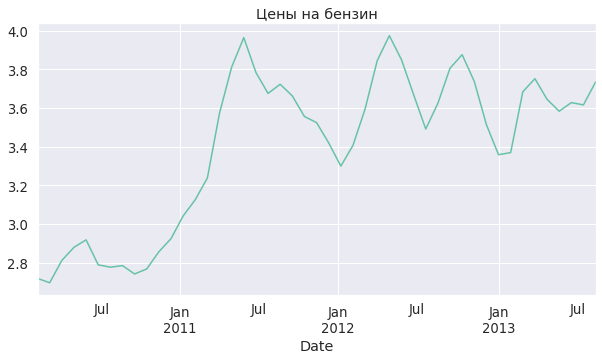

In [34]:
fuel_prices.plot(title="Цены на бензин", figsize=(10, 5));

#### shift, diff, pct_change

А потом попросили предоставить процентное изменение цены во времени.

Попробуем выполнить задачу по следующему алгоритму. 
* Получить данные со сдвигом по времени. 
* Посчитать разницу между текущими и данными в будущем.
* Эту разницу подедить на предыдущее значение.
* Перевести результат в проценты.

In [21]:
shifted_fuel_prices = fuel_prices.shift(periods=1)
shifted_fuel_prices.head()

Date
2010-02-28         NaN
2010-03-31    2.691967
2010-04-30    2.786706
2010-05-31    2.868538
2010-06-30    2.917350
Freq: M, Name: Fuel_Price, dtype: float64

In [27]:
pct_change_1 = (fuel_prices - shifted_fuel_prices) / shifted_fuel_prices * 100
pct_change_1.head()

Date
2010-02-28         NaN
2010-03-31    3.519319
2010-04-30    2.936522
2010-05-31    1.701641
2010-06-30   -4.433628
Freq: M, Name: Fuel_Price, dtype: float64

Вместо `shift` и отнимания, можно использовать `diff`.

In [28]:
pct_change_2 = fuel_prices.diff() / shifted_fuel_prices * 100
pct_change_2.head()

Date
2010-02-28         NaN
2010-03-31    3.519319
2010-04-30    2.936522
2010-05-31    1.701641
2010-06-30   -4.433628
Freq: M, Name: Fuel_Price, dtype: float64

А можно вместо всех этих операций просто использовать `pct_change`.

In [24]:
pct_change_3 = fuel_prices.pct_change() * 100
pct_change_3.head()

Date
2010-02-28         NaN
2010-03-31    3.519319
2010-04-30    2.936522
2010-05-31    1.701641
2010-06-30   -4.433628
Freq: M, Name: Fuel_Price, dtype: float64

Наконец отобразим график процентных изменений средней цены нефти.

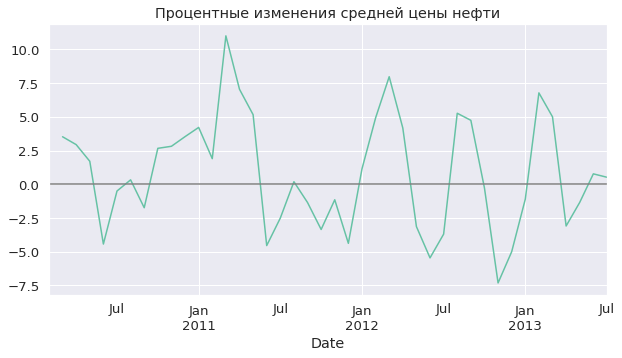

In [25]:
pct_change_3.plot(figsize=(10, 5), title='Процентные изменения средней цены нефти')
plt.axhline(c='gray');

Перейдем к данным из колонки `IsHoliday`. Данные ограничены июлем 2013 года. Праздничные недели скорее всего циклины по годам. На основе этого предположения, посчитаем какие недели были праздничными до конца 2013 года.

Для начала удалим все повторяющиеся пары неделя/праздник.

#### drop_duplicates

In [26]:
holidays = features[['Date', 'IsHoliday']].drop_duplicates()

Удостоверимся, что не бывает недель с неоднозначным состоянием праздничная/не праздничная.

In [27]:
np.unique(holidays['Date'], return_counts=True)[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Далее будем работать с данными как с `Series`. В качестве идекса устновим дату.

In [28]:
holidays = holidays.set_index('Date').squeeze()
holidays.head()

Date
2010-02-05    False
2010-02-12     True
2010-02-19    False
2010-02-26    False
2010-03-05    False
Name: IsHoliday, dtype: bool

#### date_range
Вычислим даты для каждой недели вплоть до конца года день, когда будут записываться данные. В этом нам поможет функция `date_range`.

In [29]:
future_dates = pd.date_range(
    start=holidays.index[-1], 
    end=pd.to_datetime('31.12.2013', dayfirst=True),
    freq='7D'
)[1:]
future_dates

DatetimeIndex(['2013-08-02', '2013-08-09', '2013-08-16', '2013-08-23',
               '2013-08-30', '2013-09-06', '2013-09-13', '2013-09-20',
               '2013-09-27', '2013-10-04', '2013-10-11', '2013-10-18',
               '2013-10-25', '2013-11-01', '2013-11-08', '2013-11-15',
               '2013-11-22', '2013-11-29', '2013-12-06', '2013-12-13',
               '2013-12-20', '2013-12-27'],
              dtype='datetime64[ns]', freq='7D')

Создадим `Series` с новыми датами. В качестве значений мы возьмем те же значения, что были год назад. Для того, чтобы вычислить нужные даты предыдущего года, от новых отнимем 364 дня. Потому что 364 делится на 7. Чтобы обозначить дни будем использовать класс `Timedelta`.

In [30]:
future_holidays = pd.Series(
    data=holidays.loc[future_dates - pd.Timedelta('364D')].values, 
    index=future_dates
)
future_holidays

2013-08-02    False
2013-08-09    False
2013-08-16    False
2013-08-23    False
2013-08-30    False
2013-09-06     True
2013-09-13    False
2013-09-20    False
2013-09-27    False
2013-10-04    False
2013-10-11    False
2013-10-18    False
2013-10-25    False
2013-11-01    False
2013-11-08    False
2013-11-15    False
2013-11-22     True
2013-11-29    False
2013-12-06    False
2013-12-13    False
2013-12-20    False
2013-12-27     True
Freq: 7D, dtype: bool

#### append, concat
Теперь объединим полученные даты с прошлыми. Таким образом у нас будут данные о том, какая неделя праздничная вплоть до конца 2013 года.

In [31]:
new_holidays = holidays.append(future_holidays)
new_holidays

2010-02-05    False
2010-02-12     True
2010-02-19    False
2010-02-26    False
2010-03-05    False
              ...  
2013-11-29    False
2013-12-06    False
2013-12-13    False
2013-12-20    False
2013-12-27     True
Length: 204, dtype: bool

То же самое мы можем сделать с помощью concat.

In [32]:
new_holidays = pd.concat([holidays, future_holidays])
new_holidays

2010-02-05    False
2010-02-12     True
2010-02-19    False
2010-02-26    False
2010-03-05    False
              ...  
2013-11-29    False
2013-12-06    False
2013-12-13    False
2013-12-20    False
2013-12-27     True
Length: 204, dtype: bool

### Объединения, группировки, сводные таблицы

Считаем все данные с Walmart.

In [33]:
features = pd.read_csv("./Walmart/features.csv", parse_dates=['Date'])
features.head()

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN  211.350143         8.106      False

In [34]:
sales = pd.read_csv("./Walmart/train.csv", parse_dates=['Date'])
sales.head()

Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False

In [35]:
stores = pd.read_csv("./Walmart/stores.csv")
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

#### shape
Выведем размеры данных, чтобы было понятно, с какими масштабами мы работаем.

In [36]:
features.shape, sales.shape, stores.shape

((8190, 12), (421570, 5), (45, 3))

#### merge

Объединим данные в одну таблицу. Для этого быдем использовать функцию `merge`. Заметим, что мы используем именно left-join, потому что нам важнее всего данные о продажах `sales`.

In [37]:
data = sales.merge(features, how='left').merge(stores, how='left')
data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

#### describe
Можно посмотреть на сводную стастику полученной таблицы.

In [38]:
data.describe()

Store           Dept   Weekly_Sales    Temperature  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123      60.090059   
std        12.785297      30.492054   22711.183519      18.447931   
min         1.000000       1.000000   -4988.940000      -2.060000   
25%        11.000000      18.000000    2079.650000      46.680000   
50%        22.000000      37.000000    7612.030000      62.090000   
75%        33.000000      74.000000   20205.852500      74.280000   
max        45.000000      99.000000  693099.360000     100.140000   

          Fuel_Price      MarkDown1      MarkDown2      MarkDown3  \
count  421570.000000  150681.000000  111248.000000  137091.000000   
mean        3.361027    7246.420196    3334.628621    1439.421384   
std         0.458515    8291.221345    9475.357325    9623.078290   
min         2.472000       0.270000    -265.760000     -29.100000   
25%         2.933000    2240.270000      41.600000       5.080000   
50%         3.452000    5347.450000     192.000000      24.600000   
75%         3.738000    9210.900000    1926.940000     103.990000   
max         4.468000   88646.760000  104519.540000  141630.610000   

           MarkDown4      MarkDown5            CPI   Unemployment  \
count  134967.000000  151432.000000  421570.000000  421570.000000   
mean     3383.168256    4628.975079     171.201947       7.960289   
std      6292.384031    5962.887455      39.159276       1.863296   
min         0.220000     135.160000     126.064000       3.879000   
25%       504.220000    1878.440000     132.022667       6.891000   
50%      1481.310000    3359.450000     182.318780       7.866000   
75%      3595.040000    5563.800000     212.416993       8.572000   
max     67474.850000  108519.280000     227.232807      14.313000   

                Size  
count  421570.000000  
mean   136727.915739  
std     60980.583328  
min     34875.000000  
25%     93638.000000  
50%    140167.000000  
75%    202505.000000  
max    219622.000000

Посмотрим, какие типы магазинов у нас имеются. Для этого выделим уникальные типы.

In [39]:
data.Type.unique()

array(['A', 'B', 'C'], dtype=object)

#### groupby
Сгруппируем магазины по типу и дате, посмотрим на средние продажи для каждого типа магазинов.

In [40]:
types_data = data.groupby(['Type', 'Date']).mean()['Weekly_Sales']
types_data = types_data.reset_index()
types_data.head()

Type       Date  Weekly_Sales
0    A 2010-02-05  21259.342758
1    A 2010-02-12  20491.118247
2    A 2010-02-19  20408.211165
3    A 2010-02-26  18598.270910
4    A 2010-03-05  19881.154702

In [41]:
pivot_table = pd.pivot_table(
    types_data, 
    values='Weekly_Sales', # значения свобной таблицы
    index='Date',          # индексы сводной таблицы
    columns='Type',        # колонки в сводной таблице
)
pivot_table.head()

Type                   A             B             C
Date                                                
2010-02-05  21259.342758  12859.441793   9629.645000
2010-02-12  20491.118247  12490.638919  10121.278646
2010-02-19  20408.211165  12470.015969   9372.884932
2010-02-26  18598.270910  11477.154494   9322.281724
2010-03-05  19881.154702  12238.539213   9836.001306

Теперь мы легко можем отобразить средние продажи для каждого из типа магазинов.

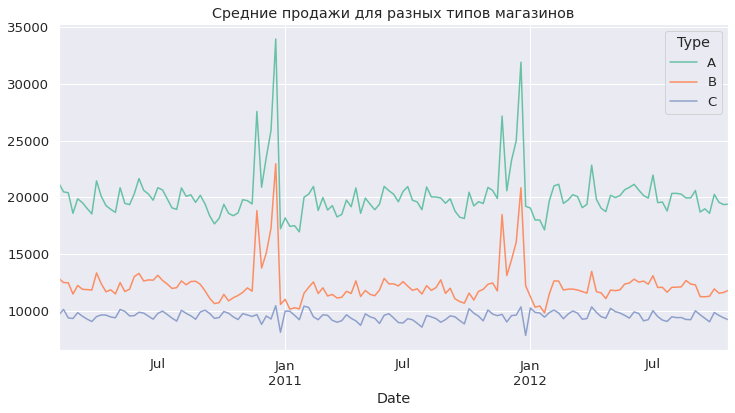

In [42]:
pivot_table.plot(figsize=(12, 6), title="Cредние продажи для разных типов магазинов");

### Немного про визуализацию
Рассмотрим данные о скидах/уценках. Получим усреднные показатели скидок с помощью `groupby`.

In [43]:
md_data = data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Date']]\
    .groupby('Date').mean()
md_data = md_data.fillna(0)
md_data

MarkDown1  MarkDown2  MarkDown3    MarkDown4    MarkDown5
Date                                                                   
2010-02-05     0.000000   0.000000   0.000000     0.000000     0.000000
2010-02-12     0.000000   0.000000   0.000000     0.000000     0.000000
2010-02-19     0.000000   0.000000   0.000000     0.000000     0.000000
2010-02-26     0.000000   0.000000   0.000000     0.000000     0.000000
2010-03-05     0.000000   0.000000   0.000000     0.000000     0.000000
...                 ...        ...        ...          ...          ...
2012-09-28  4890.992718  24.636408   6.823260  1924.698826  4243.310476
2012-10-05  5126.740027   0.000000  21.145559  3181.931490  3618.938508
2012-10-12  1955.152860   0.000000  17.306717   645.197893  5609.802120
2012-10-19  1916.437102   0.000000  13.905745   512.072616  3306.170729
2012-10-26  5025.856419  68.773298  85.632513   771.635103  1891.406624

[143 rows x 5 columns]

Также получим усредненные данные о продажах.

In [44]:
sales_data = data.groupby('Date')['Weekly_Sales'].mean()
sales_data

Date
2010-02-05    16836.121997
2010-02-12    16352.056032
2010-02-19    16216.658979
2010-02-26    14899.549688
2010-03-05    15921.015727
                  ...     
2012-09-28    14765.327279
2012-10-05    15983.413747
2012-10-12    15427.596739
2012-10-19    15295.732397
2012-10-26    15391.725681
Name: Weekly_Sales, Length: 143, dtype: float64

Выделим информацию о праздничных неделях.

In [45]:
holidays = data[["IsHoliday", "Date"]].drop_duplicates().set_index("Date").squeeze()
holidays = holidays[holidays].index
holidays

DatetimeIndex(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
               '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
               '2012-02-10', '2012-09-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

Посторим вместе графики скидок и продаж, чтобы наглядно показать закономерность.

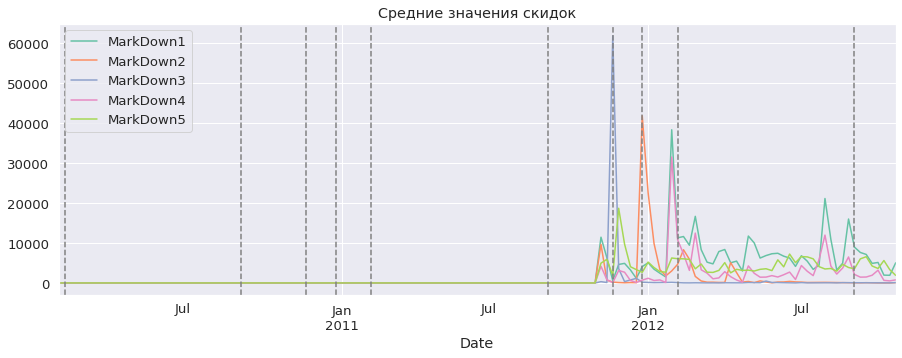

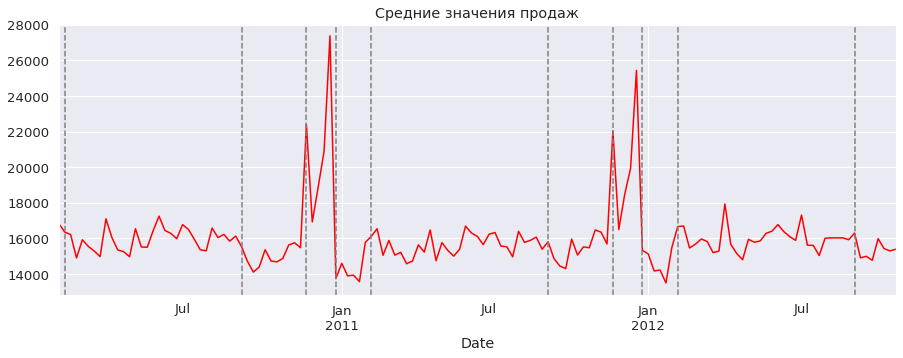

In [46]:
md_data.plot(figsize=(15, 5), title="Средние значения скидок")
for date in holidays:
    plt.axvline(date, c='gray', linestyle='--')
plt.show()

sales_data.plot(figsize=(15, 5), title="Средние значения продаж", c='red')
for date in holidays:
    plt.axvline(date, c='gray', linestyle='--')
plt.show()

В данном случае графики нас устраивают. Различных видов скидок не так много и нам просто с ними разобраться. Однако бывают неприятные случаи, когда хочется от графика большего.

Вспомним функцию `resample` и посчитаем суммарный месячный доход для каждого магазина. Но для начала удалим лишние колонки.

In [47]:
sales_new = sales.drop(columns=['Dept', 'IsHoliday'])
sales_new

Store       Date  Weekly_Sales
0           1 2010-02-05      24924.50
1           1 2010-02-12      46039.49
2           1 2010-02-19      41595.55
3           1 2010-02-26      19403.54
4           1 2010-03-05      21827.90
...       ...        ...           ...
421565     45 2012-09-28        508.37
421566     45 2012-10-05        628.10
421567     45 2012-10-12       1061.02
421568     45 2012-10-19        760.01
421569     45 2012-10-26       1076.80

[421570 rows x 3 columns]

Text(0.5, 1.0, 'Monthly sales')

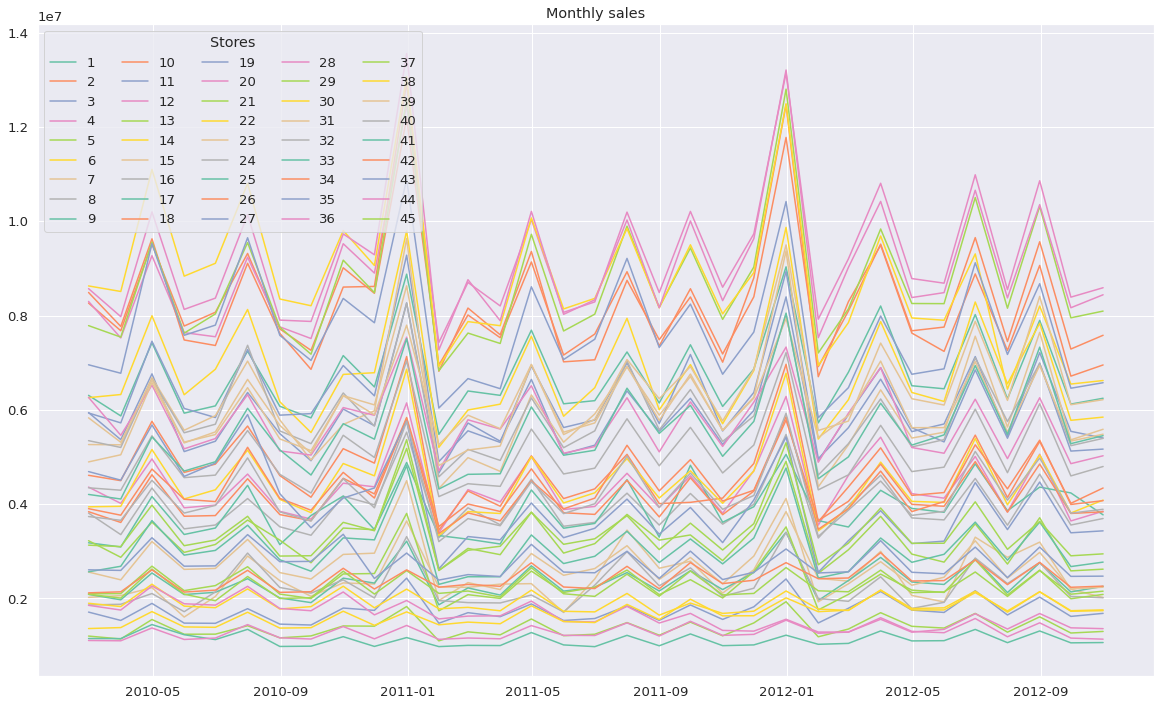

In [48]:
plt.figure(figsize=(20, 12))
for store, store_sales in sales_new.groupby('Store'):
    month_sales = store_sales.set_index('Date').resample('1m').sum()
    plt.plot(month_sales["Weekly_Sales"], label=store)
plt.legend(ncol=5, title="Stores", loc='upper left')
plt.title("Monthly sales")

График получился довольно запутанным. Магазинов много и не понятно, какой какому цвету соотвествует. 
Это можно исправить с помощью интерактивной визуализации с помощью `plotly`.

In [49]:
fig = go.Figure()

for store, store_sales in sales_new.groupby('Store'):
    month_sales = store_sales.set_index('Date').resample('1m').sum()
    fig.add_trace(go.Scatter(x=month_sales.index, 
                             y=month_sales["Weekly_Sales"], 
                             name=f"Store {store}"))

fig.update_layout(
    width=900,
    height=1000,
    title_text="Суммарные месячные продажи",
    title_font_size=20,
    yaxis_title="Продажи",
    xaxis_title="Дата",
    xaxis_rangeslider_visible=True, # слайдер
)

fig.show()

Перейдем [по ссылке](https://mipt-stats.gitlab.io/courses/ad_fivt/plotly.html) к разбору библиотеки `plotly`.

## Декомпозиция временных рядов

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pylab import rcParams

### Данные Walmart
Применим методы декомпозиции временных рядов к суммарным данным о продажах.

In [51]:
sales_data = sales.groupby('Date').sum()['Weekly_Sales']
sales_data

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

#### Простая аддитивная декомпозиция

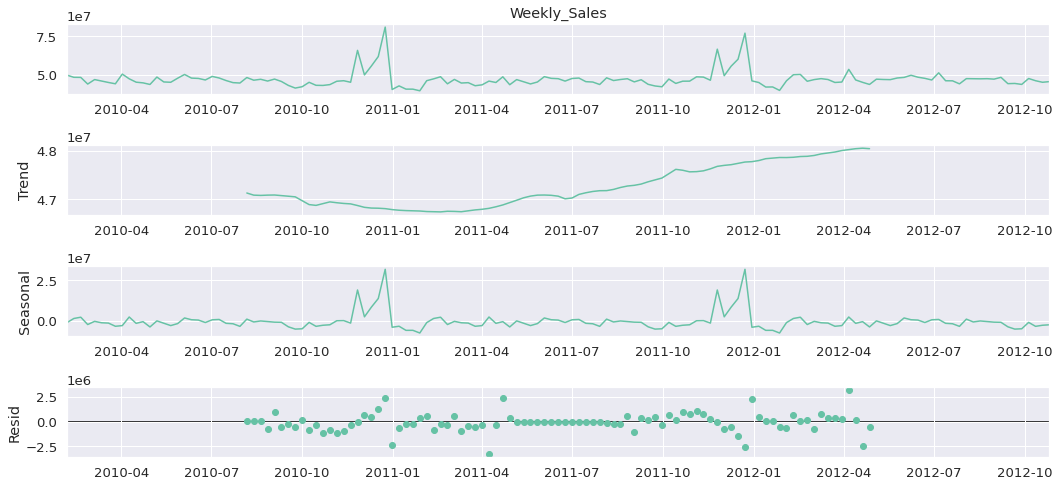

In [52]:
rcParams['figure.figsize'] = 15, 7
simple_result = seasonal_decompose(sales_data, model='additive', period=52)
simple_result.plot();

Наблюдаем негладкий тренд и очень странные остатки. Сознность практически совпадает с тсходным графиком.

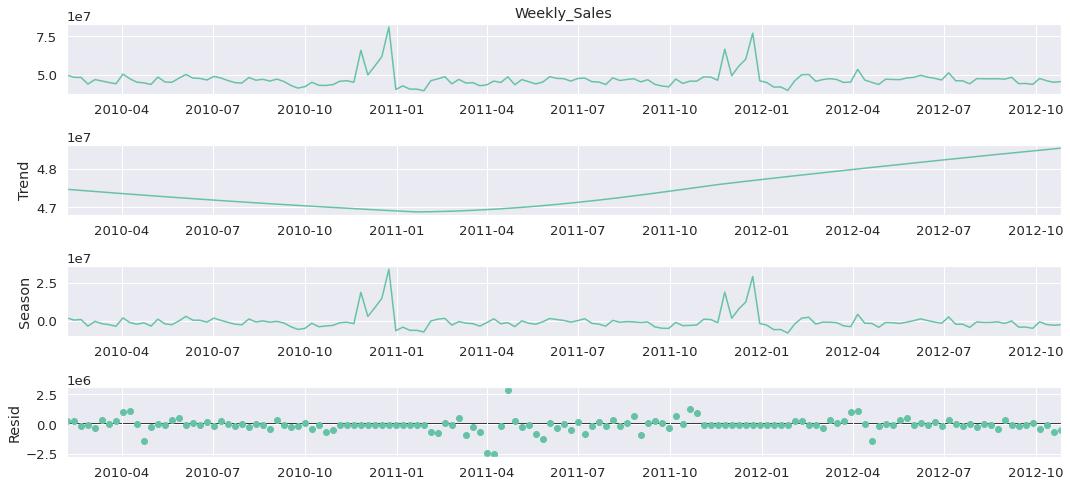

In [53]:
result = STL(sales_data, period=52).fit()
result.plot();

Тренд стал гладким. Остатки прняли чуть более нормальный вид.

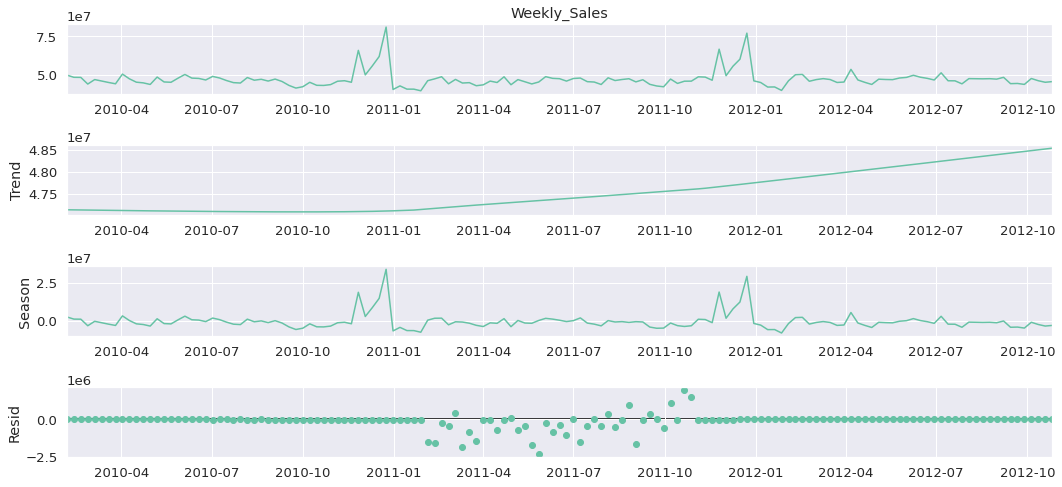

In [54]:
robust_result = STL(sales_data, period=52, robust=True).fit()
robust_result.plot();

Сильно лучше не стало.

В данном примере есть проблема с сезонностью &mdash; она абсолютно не информативна. Давайте попробуем сдлетаь то же самое на других данных. Загрузим датасет про ежемесячные продажи антидиабетических препаратов в Австралии с 1992 по 2008 год.

### Данные об антиадиабетических препаратах

In [55]:
title = 'Monthly anti-diabetic drug sales in Australia from 1992 to 2008' 
antidiab = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])
antidiab.index = antidiab['date']
antidiab = antidiab.drop(columns=['date']).squeeze()
antidiab

date
1991-07-01     3.526591
1991-08-01     3.180891
1991-09-01     3.252221
1991-10-01     3.611003
1991-11-01     3.565869
                ...    
2008-02-01    21.654285
2008-03-01    18.264945
2008-04-01    23.107677
2008-05-01    22.912510
2008-06-01    19.431740
Name: value, Length: 204, dtype: float64

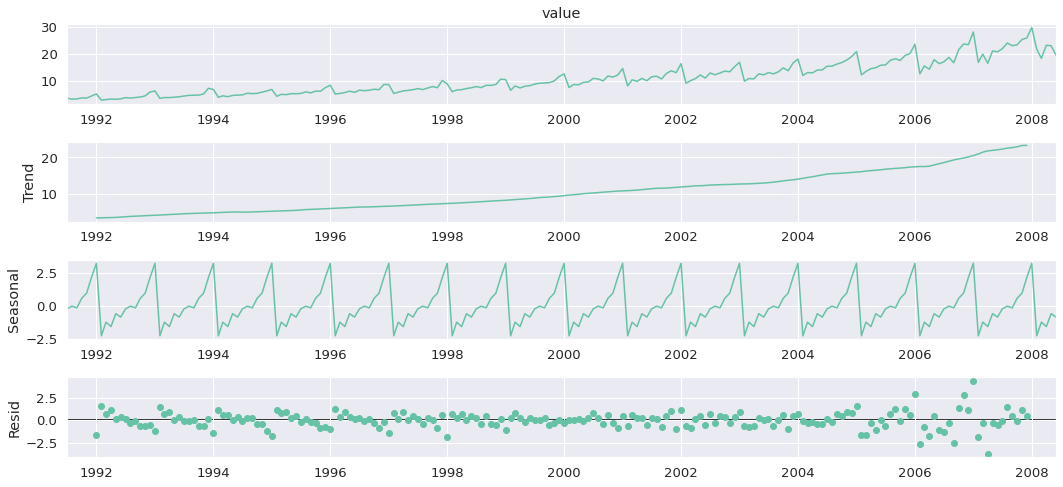

In [56]:
simple_result = seasonal_decompose(antidiab, model='additive', period=12)
simple_result.plot();

Наблюдаем хорошую сезонность, но остатки не похожи на нормальные.

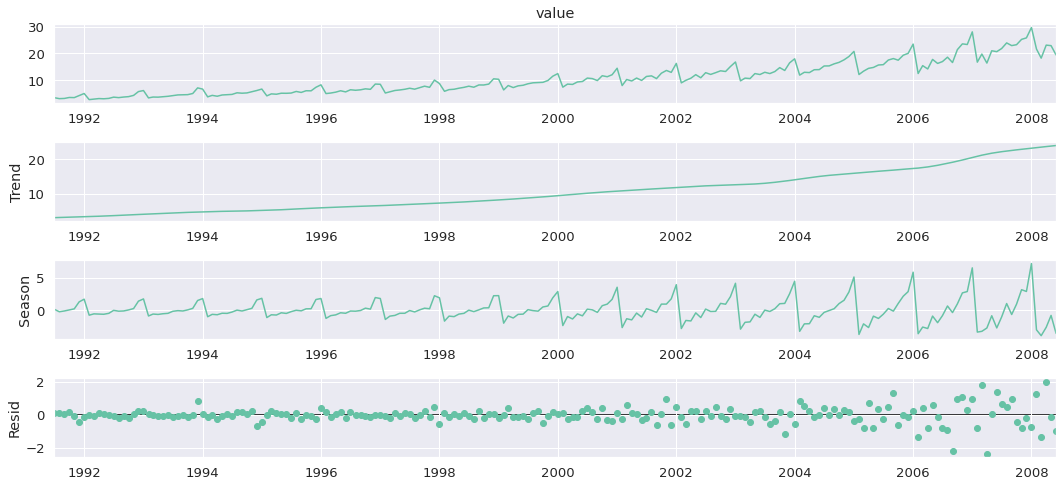

In [57]:
result = STL(antidiab, period=12).fit()
result.plot();

В остатках исчезла периодичность, но зато появилась динамика.

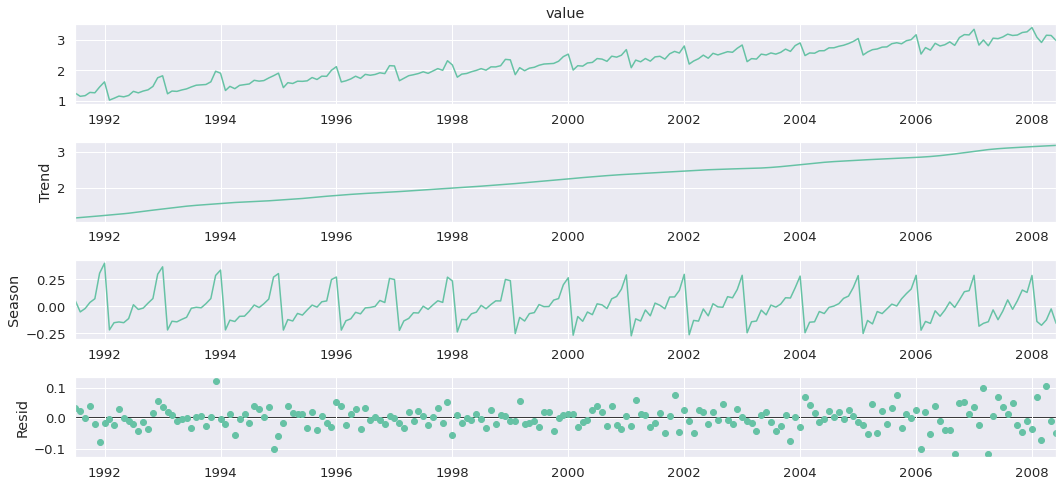

In [58]:
log_antidiab = pd.Series(np.log(antidiab), index=antidiab.index)
result = STL(log_antidiab, period=12).fit()
result.plot();

Сезонность и остатки стали выглядеть гораздо лучше.